In [1]:
import os
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from tokenizers import Tokenizer

In [2]:
from torchvision.io import read_image

from src.data.cv_utils import display_images
from src.utils import load_from_checkpoint

from src.models.CLIP_Loss import CLIPLoss
from src.models.CLIP_model import CLIPModule

from src.models.computer_vision.backbones.vit import ViTBaseOver16at112, ViTBaseOver32at224, ViTSmallOver16at112, ViTMicroOver14at112
from src.models.natural_language_processing.nlp_backbones import GPTSmall, GPTBase, GPTLarge

In [13]:
image_path = "data/demoimages"
tokenizer_file = "src/data/nlp/tokenizers/CLIP-bpe.tokenizer.json"
img_res = 224

In [46]:
device = 'cpu'
use_checkpoint = False

vocab_size = 20000
clip_embedding_dim = 512
max_length = 32

text_dim_out = 512
image_dim_out = 768

In [68]:
def load_dataset(image_dir, img_res):
    image_files = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
    
    text = [x.replace('.jpg', '').replace(image_dir+"/", '') for x in image_files]
    images = torch.cat([torch.unsqueeze(read_image(img), 0) for img in image_files], dim=0)
    
    _, w, h = images[0].shape
    
    factor = img_res / min(w, h)
    new_width = int(w * factor)
    new_height = int(h * factor)

    images = T.Resize((new_height, new_width), antialias=True)(images)
    images = T.RandomCrop((img_res, img_res))(images)
    
    return images, text

In [69]:
def load_clip_backbone(image_encoder, text_encoder, device):
    
    image_model = None
    image_resolution = None
    if image_encoder == "B/32@224":
        image_model = ViTBaseOver32at224(dim_out=image_dim_out).to(device)
        image_resolution = 224
    if image_encoder == "B/16@112":
        image_model = ViTBaseOver16at112(dim_out=image_dim_out).to(device)
        image_resolution = 112
    if image_encoder == "S/16@112":
        image_model = ViTSmallOver16at112(dim_out=image_dim_out).to(device)
        image_resolution = 112
    if image_encoder == "M/14@112":
        image_model = ViTMicroOver14at112(dim_out=image_dim_out).to(device)
        image_resolution = 112
        
    text_model = None
    if text_encoder == "S":
        text_model = GPTSmall(dim_out=text_dim_out, vocab_size=vocab_size, max_length=max_length, use_checkpoint=use_checkpoint, device=device).to(device)
    if text_encoder == "B":
        text_model = GPTBase(dim_out=text_dim_out, vocab_size=vocab_size, max_length=max_length, use_checkpoint=use_checkpoint, device=device).to(device)
    if text_encoder == "L":
        text_model = GPTLarge(dim_out=text_dim_out, vocab_size=vocab_size, max_length=max_length, use_checkpoint=use_checkpoint, device=device).to(device)

    clip_model = CLIPModule(image_encoder=image_model, text_encoder=text_model, dim_img=image_dim_out, dim_text=text_dim_out, embedding_dim=clip_embedding_dim, temperature=0.07).to(device)
    
    return clip_model


def tokenize(tokenizer, query, max_length):
    # Encode sequence
    encoded_query = tokenizer.encode(query).ids

    # Truncate query if necessary
    encoded_query = encoded_query[:max_length-2]

    # Add end_of_sentence token [EOS]
    encoded_query += [tokenizer.token_to_id('[EOS]')]

    # Add padding to encoded sentence
    encoded_query += [0] * (max_length - len(encoded_query) - 1)

    # Add [SOS] and [EOS] tokens
    encoded_query = [tokenizer.token_to_id('[SOS]')] + encoded_query
    
    return encoded_query

In [70]:
def load_clip(clip_model):
    checkpointsdir = "src/models/checkpoints"
    
    if clip_model == "ViT-Base/32 @ 224px":
        clip = load_clip_backbone(image_encoder="B/32@224", text_encoder="B", device=torch.device('cpu'))
        clip, _, loss_hist = load_from_checkpoint(os.path.join(checkpointsdir, "CLIP_epoch_3_2023-07-01_21:04:05"), clip)
        
    if clip_model == "ViT-Base/16 @ 112px":
        clip = load_clip_backbone(image_encoder="B/16@112", text_encoder="B", device=torch.device('cpu'))
        clip, _, loss_hist = load_from_checkpoint(os.path.join(checkpointsdir, "CLIP_epoch_2_"), clip)
    
    return clip
    

# Load data

3 3


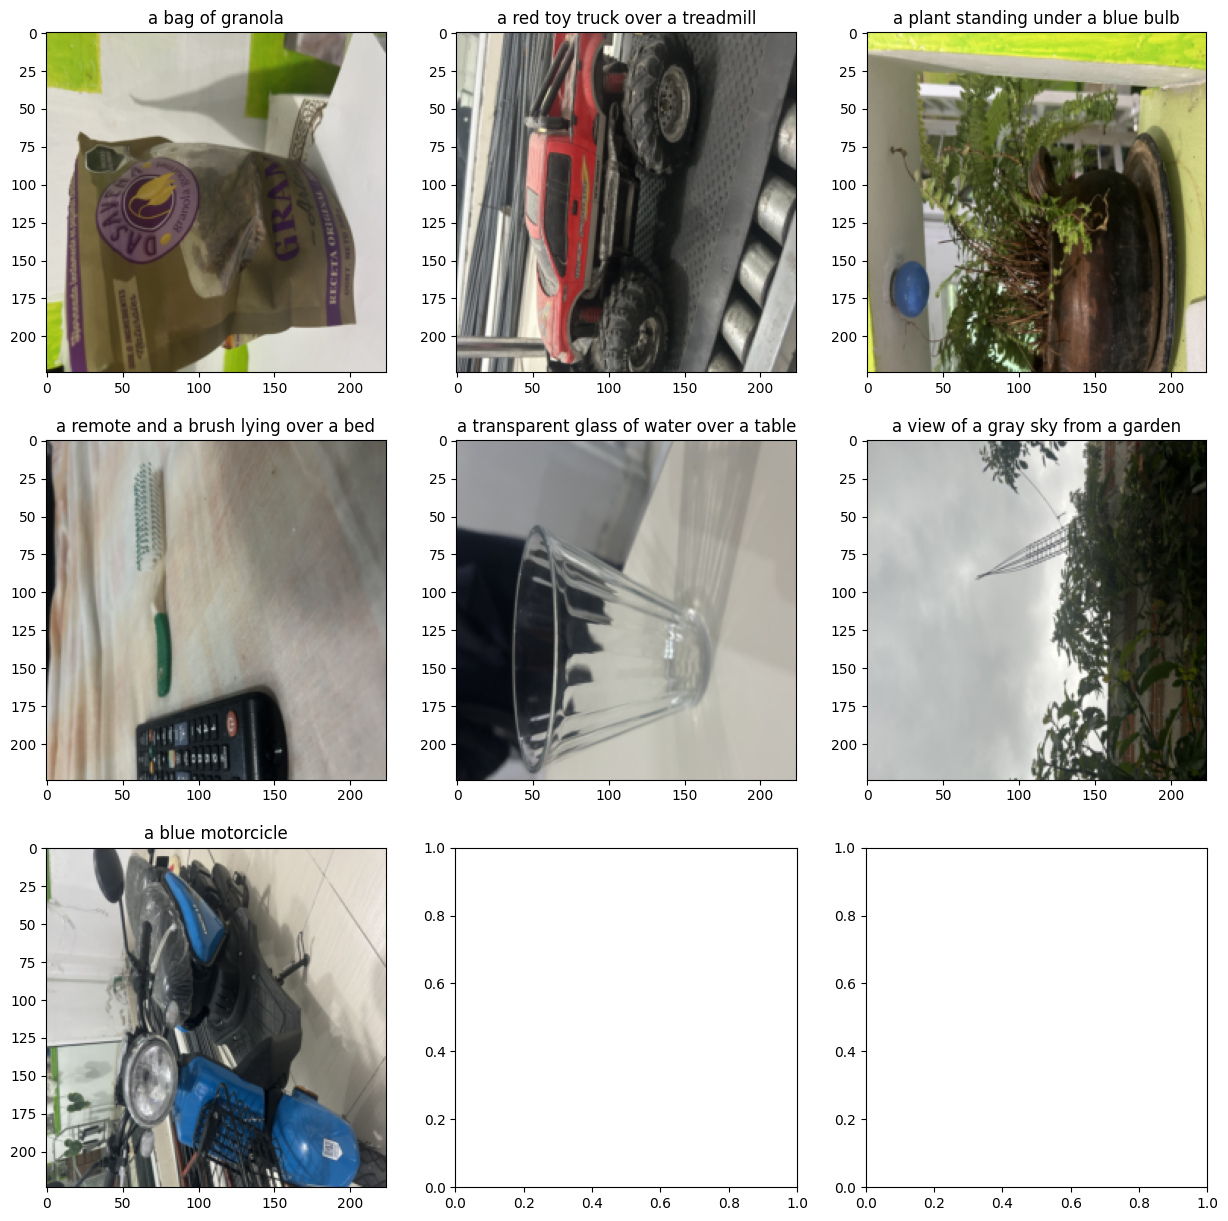

In [71]:
images, text = load_dataset(image_path, img_res)
display_images(images, text)

## Load Model

In [51]:
clip_base = load_clip("ViT-Base/32 @ 224px")
print("CLIP Base Parameters:", np.sum([ np.prod(x.shape) for x in clip_base.parameters() ]))
print(type(clip_base))

CLIP successfully loaded from src/models/checkpoints/CLIP_epoch_3_2023-07-01_21:04:05
CLIP Base Parameters: 161361920
<class 'src.models.CLIP_model.CLIPModule'>


In [24]:
# clip = load_clip_backbone(image_encoder="B/16@112", text_encoder="B", device=torch.device('cpu'))
# np.sum([ np.prod(x.shape) for x in clip.parameters() ])

139131904

In [27]:
# clip = load_clip_backbone(image_encoder="S/16@112", text_encoder="S", device=torch.device('cpu'))
# np.sum([ np.prod(x.shape) for x in clip.parameters() ])

55987456

In [37]:
161361920 / 161361920, 139131904 / 161361920, 55987456 / 161361920

(1.0, 0.8622350552100521, 0.3469682066252062)

## Load Tokenizer

In [94]:
tokenizer = Tokenizer.from_file(tokenizer_file)
tokens = torch.Tensor([tokenize(tokenizer, x, max_length) for x in text]).to(dtype=torch.int)

### Compute zero-shot weights for classification

In [108]:
logits_img, logits_txt = clip_base(images.to(dtype=torch.float), tokens)

AttributeError: AxesImage.set() got an unexpected keyword argument 'vim'

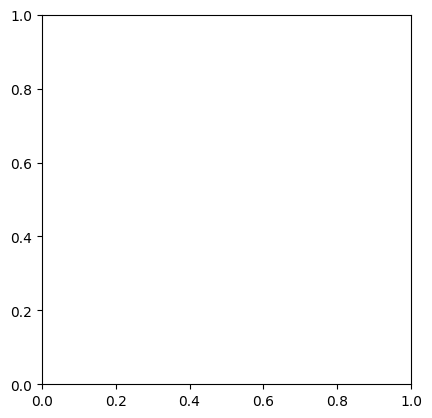

In [113]:
plt.imshow(logits_img.detach().numpy(), vim=-1.0, vmax=1.0)
plt.show()

In [110]:
logits_img

tensor([[ 2.6311,  1.7589,  2.0780,  3.1881,  2.2037,  0.9104,  2.2801],
        [ 2.1926,  3.5842,  1.6388,  1.2441,  0.4832, -2.2364,  2.0133],
        [ 1.8235,  1.6055,  4.1521,  0.9561,  2.1623,  2.8430,  2.8598],
        [ 3.0271,  0.9110,  3.8762,  4.5327,  3.7191, -2.1661,  2.9541],
        [ 3.1094,  0.1837,  3.4562,  4.7269,  3.9059, -0.9506,  4.7063],
        [ 3.3699,  0.0317,  2.9292,  2.4207,  3.9309,  3.8371,  1.3394],
        [ 1.4160, -0.4044,  4.5348,  1.9262,  2.0344,  0.0549,  3.7912]],
       grad_fn=<MulBackward0>)